## Probando conexion con la base de datos

In [3]:
pip install python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")
    
    # Create a cursor to execute SQL queries
    cursor = connection.cursor()
    
    # Example query
    cursor.execute("SELECT NOW();")
    result = cursor.fetchone()
    print("Current Time:", result)

    # Close the cursor and connection
    #cursor.close()
    #connection.close()
    #print("Connection closed.")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!
Current Time: (datetime.datetime(2025, 9, 29, 6, 20, 56, 854449, tzinfo=datetime.timezone.utc),)


In [7]:
cursor = connection.cursor()
cursor.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public'
""")

tables = cursor.fetchall()
print("Tablas encontradas:")
for table in tables:
    print(table[0])

cursor.close()

Tablas encontradas:
n8n_chat_histories
airbnb_listings_final
geography_columns
geometry_columns
spatial_ref_sys
scraped_data
tweets_results
google_search
trivago_hoteles
facebook_posts


In [8]:
table_name = 'facebook_posts'  # cámbialo por tu tabla real

cursor = connection.cursor()
cursor.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = %s
""", (table_name,))

columns = cursor.fetchall()
print(f"Columnas en {table_name}:")
for column in columns:
    print(f"- {column[0]} ({column[1]})")

cursor.close()

Columnas en facebook_posts:
- comment_count (integer)
- view_count (integer)
- music (jsonb)
- reactions_count (integer)
- comments (jsonb)
- video (jsonb)
- created_at (timestamp with time zone)
- feedback_id (text)
- author_id (text)
- transcript (text)
- share_count (text)
- like_count (text)
- post_id (text)
- image_url (text)
- author (text)
- description (text)
- url (text)
- thumbnail (text)
- video_url (text)
- captions_url (text)


In [9]:
pip install hdfs

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdfs: filename=hdfs-2.7.3-py3-none-any.whl size=34431 sha256=41a831d9ac69301d9701a45b7c4ab77b3ae476956439db3aa5dd8ce50ae5dfa3
  Stored in directory: /home/upao/.cache/pip/wheels/b9/1d/dc/eb0833be25464c359903d356c4204721c6a672c26ff164cdc3
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13783 sha256=8e539a6cb72f157660373527973aa6b5f05b196b334ebef353d7b7a81673c57c
  Stored in directory: /home/upao/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built hdfs docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [hdfs]
Note: you may need to restart the kernel to use updated packages.


## Extraemos la data y la almacenamos en nuestro almacenamiento distribuido

In [9]:
import pandas as pd
import psycopg2

# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Conexión a tu base de datos
connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )

table_name = 'facebook_posts'
query = f"SELECT * FROM {table_name};"

df = pd.read_sql(query, connection)
print(df.head())

connection.close()

/tmp/ipykernel_21836/2662325399.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


            post_id                  author  \
0   732574745273542      Luisito el das das   
1  1604314470532320             SC Gonzalez   
2  1467005400929895  Michel Dubraska Alfano   
3  2908275766022845         Rajib Choudhury   
4   941195313282924        কাঁচা মিঠে ট্যুর   

                                         description  \
0  Hoy les voy a mostrar un lugar muy bonito y es...   
1  If I have 4 days in Delhi … what are the place...   
2  I have one extra day in New Delhi, any ideas o...   
3                       India Gate 🇮🇳\n\n📍 New Delhi   
4  In this video i describe about 15 Top-Rated To...   

                                                 url  \
0  https://www.facebook.com/luisitodasdas1/videos...   
1  https://www.facebook.com/groups/38573540239023...   
2  https://www.facebook.com/groups/38573540239023...   
3  https://www.facebook.com/groups/15285565906614...   
4  https://www.facebook.com/109097457260426/video...   

                                           

In [10]:
# Guardar como CSV
df.to_csv("facebook_posts.csv", index=False)

In [2]:
from hdfs import InsecureClient

In [13]:
client = InsecureClient('http://localhost:9870', user='upao')

# Subir archivo
client.upload('/user/upao/raw/facebook/facebook_posts.csv', 'facebook_posts.csv', overwrite=True)
print("Archivo subido correctamente")

Archivo subido correctamente


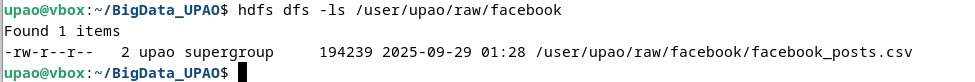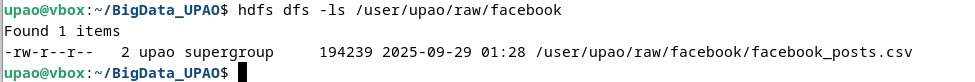

# Procesar los datos

## Api Facebook

In [10]:
from pyspark.sql import SparkSession

# Iniciar Spark
spark = SparkSession.builder \
    .appName("FacebookPostsProcessing") \
    .getOrCreate()

# Leer CSV desde HDFS
raw_df = spark.read.option("header", True).csv("hdfs://localhost:9000/user/upao/raw/facebook/facebook_posts.csv")

# Ver esquema
raw_df.printSchema()
raw_df.show(5)

root
 |-- post_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- description: string (nullable = true)
 |-- url: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- video_url: string (nullable = true)
 |-- captions_url: string (nullable = true)
 |-- feedback_id: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- reactions_count: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- transcript: string (nullable = true)
 |-- music: string (nullable = true)
 |-- share_count: string (nullable = true)
 |-- like_count: string (nullable = true)
 |-- video: string (nullable = true)
 |-- image_url: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--

### Seleccionamos las columnas que nos serviran

In [7]:
import ast
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,regexp_replace, from_json, explode
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType

In [4]:
## Datos de post ##
posts_columns = [
    "post_id",
    "author",
    "description",
    "author_id",
    "created_at",
    "reactions_count",
    "comment_count"
]

posts_df = raw_df.select(*posts_columns)

# Revisar el resultado
posts_df.show(5)
posts_df.printSchema()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|             post_id|              author|         description|           author_id|          created_at|     reactions_count|comment_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|     732574745273542|  Luisito el das das|Hoy les voy a mos...|                NULL|                NULL|                NULL|         NULL|
|A tan sólo 40 min...|https://www.faceb...|https://scontent-...|                NULL|                NULL|2025-09-28 17:07:...|          970|
|    1604314470532320|         SC Gonzalez|If I have 4 days ...|                NULL|                NULL|                NULL|         NULL|
|  Interested in food|             museums|             temples|                  29|                NULL|ZmVlZGJhY2s6MTYwN...|         NULL|
|    1

### Depurando errores

In [12]:
# Filtrar por post_id
single_post_df = raw_df.filter(col("post_id") == "606326448590140")

# Mostrar el registro completo
single_post_df.show(truncate=500)

+---------------+-----------+----------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+---------+---------+------------+--------------------------------+-------------+----------+---------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------+---------------+----------+-----+-----------+----------+-----+---------+
|        p

In [40]:
# Reemplazar comillas simples por dobles en 'comments'
raw_df_clean = raw_df.withColumn(
    "comments_clean",
    regexp_replace("comments", "'", '"')
)

In [41]:
raw_df_nonull = raw_df_clean.filter(raw_df_clean.comments_clean.isNotNull())

comments_schema = ArrayType(
    StructType([
        StructField("id", StringType(), True),
        StructField("text", StringType(), True),
        StructField("reaction_count", IntegerType(), True),
        StructField("author", StructType([
            StructField("id", StringType(), True),
            StructField("name", StringType(), True),
            StructField("gender", StringType(), True)
        ]))
    ])
)


In [42]:
# Filtrar por post_id
single_post_df = raw_df_nonull.filter(col("post_id") == "606326448590140")

# Mostrar el registro completo
single_post_df.show(truncate=500)

+---------------+-----------+----------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+---------+---------+------------+--------------------------------+-------------+----------+---------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------+---------------+----------+-----+-----------+----------+-----+---------+-----------

In [48]:
from pyspark.sql.functions import col, regexp_replace, split, explode, regexp_extract
# 1. Limpiar corchetes exteriores
clean_df = raw_df_nonull.withColumn(
    "comments_clean2",
    regexp_replace(col("comments_clean"), r"^\[|\]$", "")
)

# 2. Separar comentarios individuales por '},{' (asumiendo formato JSON consistente)
exploded_df = clean_df.withColumn(
    "comment_single",
    explode(split(col("comments_clean2"), r"\},\s*\{"))
)

# 3. Agregar llaves faltantes en los extremos de cada fragmento
exploded_df = exploded_df.withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"^", "{")
).withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"$", "}")
)

# 4. Extraer campos de cada comentario usando regex
comments_final_df = exploded_df.select(
    col("post_id"),
    regexp_extract("comment_single", r'"id":\s*"([^"]+)"', 1).alias("comment_id"),
    regexp_extract("comment_single", r'"text":\s*"([^"]+)"', 1).alias("text"),
    regexp_extract("comment_single", r'"reaction_count":\s*(\d+)', 1).cast("int").alias("reaction_count"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"id":\s*"([^"]+)"', 1).alias("author_id"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"name":\s*"([^"]+)"', 1).alias("author_name"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"gender":\s*"([^"]+)"', 1).alias("author_gender")
)

# 5. Mostrar resultado
# Filtrar por post_id
single_post_df = comments_final_df.filter(col("post_id") == "606326448590140")

# Mostrar el registro completo
single_post_df.show()

+---------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|        post_id|          comment_id|                text|reaction_count|      author_id|  author_name|author_gender|
+---------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|606326448590140|Y29tbWVudDo2MDYzM...|Hace falta más in...|             0|100048700500150|Paty Da Silva|       FEMALE|
+---------------+--------------------+--------------------+--------------+---------------+-------------+-------------+



### Limpiando datos de comentarios

In [50]:
from pyspark.sql.functions import col, regexp_replace, split, explode, regexp_extract

# Reemplazar comillas simples por dobles en 'comments'
raw_df_clean = raw_df.withColumn(
    "comments_clean",
    regexp_replace("comments", "'", '"')
)

# Eliminar nulos
raw_df_nonull = raw_df_clean.filter(raw_df_clean.comments_clean.isNotNull())

# 1. Limpiar corchetes exteriores
clean_df = raw_df_nonull.withColumn(
    "comments_clean2",
    regexp_replace(col("comments_clean"), r"^\[|\]$", "")
)

# 2. Separar comentarios individuales por '},{'
exploded_df = clean_df.withColumn(
    "comment_single",
    explode(split(col("comments_clean2"), r"\},\s*\{"))
)

# 3. Agregar llaves faltantes
exploded_df = exploded_df.withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"^", "{")
).withColumn(
    "comment_single",
    regexp_replace(col("comment_single"), r"$", "}")
)
# 4. Extraer campos de cada comentario usando regex
comments_final_df = exploded_df.select(
    col("post_id"),
    regexp_extract("comment_single", r'"id":\s*"([^"]+)"', 1).alias("comment_id"),
    regexp_extract("comment_single", r'"text":\s*"([^"]+)"', 1).alias("text"),
    regexp_extract("comment_single", r'"reaction_count":\s*(\d+)', 1).cast("int").alias("reaction_count"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"id":\s*"([^"]+)"', 1).alias("author_id"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"name":\s*"([^"]+)"', 1).alias("author_name"),
    regexp_extract("comment_single", r'"author":\s*\{[^}]*"gender":\s*"([^"]+)"', 1).alias("author_gender")
)
comments_final_df.show()

+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|             post_id|          comment_id|                text|reaction_count|           author_id|         author_name|author_gender|
+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+-------------+
|  Interested in food|                    |                    |          NULL|                    |                    |             |
|    1467005400929895|Y29tbWVudDoxNDY3M...|I work as a local...|             0|pfbid0NukdvtTBnZ7...|        Satyam Singh|         MALE|
|    1467005400929895|Y29tbWVudDoxNDY3M...|https://www.tripa...|             0|pfbid0nnD6Jsb2tNU...|         Vijay Kumar|         MALE|
|    1467005400929895|Y29tbWVudDoxNDY3M...|There are many pl...|             0|     100000499213576|       Sandeep Kumar|         MALE|
|       📍 New Delhi"|                    |      